In [1]:
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import cvxpy as cp
import random
from IPython.display import display
import time
import os
from joblib import Parallel, delayed


from src.model import Nonneg_dagma, MetMulDagma, BarrierDagma
import src.utils as utils

from colide.model import colide_ev


SEED = 10
N_CPUS = os.cpu_count() // 2

np.random.seed(SEED)
random.seed(SEED)

/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def run_exps(g, data_p, exps, thr=.2, verb=False):
    A_true, _, X = utils.simulate_sem(**data_p)
    A_true_bin = utils.to_bin(A_true, thr)
    X_norm = X/la.norm(X, axis=1, keepdims=True)

    M, N = X.shape

    fidelity = 1/data_p['n_samples']*la.norm(X - X @ A_true, 'fro')**2
    fidelity_norm = 1/data_p['n_samples']*la.norm(X_norm - X_norm @ A_true, 'fro')**2

    print(f'{g}: Fidelity: {fidelity:.3f}  -  Fidelity (norm): {fidelity_norm:.3f}')

    shd, fscore, err, acyc, runtime = [np.zeros(len(exps))  for _ in range(5)]
    for i, exp in enumerate(exps):
        X_aux = X_norm if 'norm_x' in exp.keys() and exp['norm_x'] else X

        args = exp['args'].copy()
        if 'fix_lamb' in exp.keys() and not exp['fix_lamb']:
            args['lamb'] = get_lamb_value(N, M, args['lamb'])

        model = exp['model']()
        t_i = time.time()
        A_est = model.fit(X_aux, **args)
        t_solved = time.time() - t_i

        A_est = model.W_est

        A_est_bin = utils.to_bin(A_est, thr)
        shd[i], _, _ = utils.count_accuracy(A_true_bin, A_est_bin)
        fscore[i] = f1_score(A_true_bin.flatten(), A_est_bin.flatten())
        err[i] = utils.compute_norm_sq_err(A_true, A_est)
        acyc[i] = model.dagness(A_est) if hasattr(model, 'dagness') else 1
        runtime[i] = t_solved

        if verb:
            print(f'\t-{exp["leg"]}: shd {shd[i]}  -  err: {err[i]:.3f}  -  time: {runtime[i]:.3f}')

    return shd, fscore, err, acyc, runtime

def get_lamb_value(n_nodes, n_samples, times=1):
    return np.sqrt(np.log(n_nodes) / n_samples) * times 

def compute_errsW(W_seq, W_true):
    errs = np.zeros(len(W_seq))
    norm_W_true = la.norm(W_true)
    for i, W_est in enumerate(W_seq):
        errs[i] = (la.norm(W_true - W_est)/norm_W_true)**2
    
    return errs
    
def plot_result(A_true, A_est, thr, plot_matrices=True):
    A_est_bin = utils.to_bin(A_est, thr)
    A_true_bin = utils.to_bin(A_true, thr)

    fro_err = utils.compute_norm_sq_err(A_true, A_est)
    fro_err_bin = utils.compute_norm_sq_err(A_true_bin, A_est_bin)
    sdh, _, _ = utils.count_accuracy(A_true_bin, A_est_bin)
    fscore = f1_score(A_true_bin.flatten(), A_est_bin.flatten())

    print(f'Err: {fro_err:.3f}  -  Err bin: {fro_err_bin:.3f}  -  shd: {sdh}  -  fscore: {fscore:.3f}')

    if plot_matrices:
        plt.figure(figsize=(8, 8))
        plt.subplot(2,2,1)
        plt.imshow(A_true)
        plt.colorbar()
        plt.title("A true")
        plt.subplot(2,2,2)
        plt.imshow(A_est)
        plt.colorbar()
        plt.title("A est")
        plt.subplot(2,2,3)
        plt.imshow(A_true_bin)
        plt.colorbar()
        plt.title("A true bin")
        plt.subplot(2,2,4)
        plt.imshow(A_est_bin)
        plt.colorbar()
        plt.title("A est bin")

def plot_convergence(model, W_true):

    errs_W = compute_errsW(model.seq_W, W_true)

    plt.figure(figsize=(12, 4))
    plt.subplot(1,3,1)
    plt.semilogy(model.diff)
    plt.title('Convergence of W')
    plt.subplot(1,3,2)
    plt.semilogy(errs_W)
    plt.title('Error')
    plt.subplot(1,3,3)
    plt.semilogy(model.acyclicity)
    plt.title('Acyclicity')
    plt.tight_layout()

## Quick comparisons

In [3]:
# DAG parameters
N = 100
g_type = 'er'
edges = N*4
edge_type = 'positive'  # Options: binary, positive, weighted
w_range = (.5, 1)  #(.3, .9)
norm_x = False
M = 500
variance = 1 # 1/np.sqrt(N)

A, dag, X = utils.simulate_sem(N, M, g_type, edges, permute=False, edge_type=edge_type,
                               w_range=w_range, noise_type='normal', var=variance)

if norm_x:
    X = X/la.norm(X, axis=1, keepdims=True)

print(X.shape)

print(f'Mean degree: {(A.sum(axis=0).mean()):2f}')
print('Mean norm of X:', la.norm(X, axis=1).mean())
print('Fidelity error:', 1/M*la.norm(X - X @ A, 'fro')**2)


(500, 100)
Mean degree: 2.837479
Mean norm of X: 130.7537940705763
Fidelity error: 99.89188115490819


### Proj Grad Descent DAGMA Alg

lamb: 1.9194103648752327e-05
Solved in 142.626087 seconds
Mean est value: 0.02967360483967919
Err: 0.087  -  Err bin: 0.076  -  shd: 29  -  fscore: 0.962


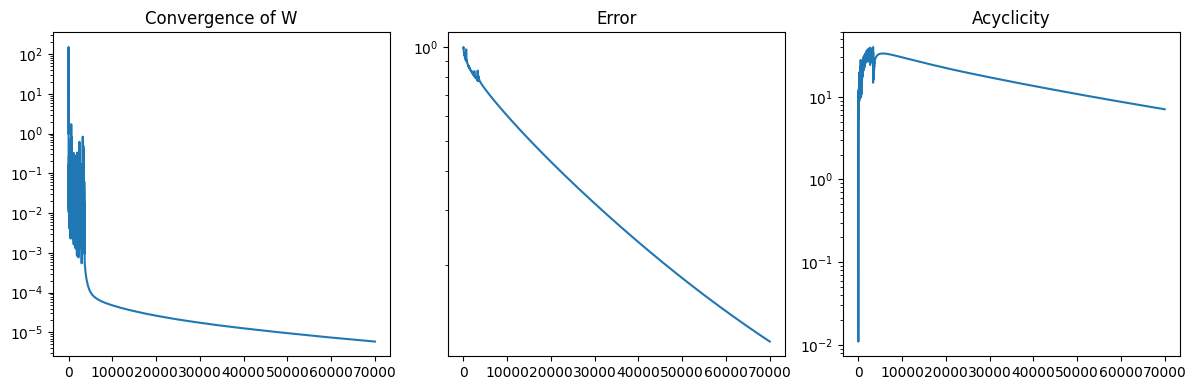

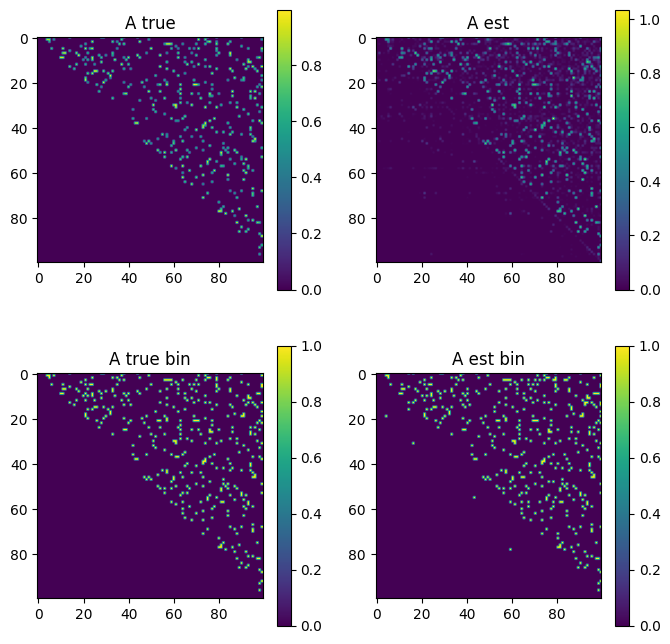

In [4]:
## Second set of hyperparams N = 50
lamb = get_lamb_value(N, M, 5e-2)
# if edges == 2*N:   
#     args = {'stepsize': 5e-2, 'alpha': .5, 's': 1, 'lamb': np.sqrt(np.log(N)/M)*2e-2, 'max_iters': 50000,
#             'tol': 1e-6,}
# else:
#     lamb = get_lamb_value(N, M, 2e-4)
#     args = {'stepsize': 1e-3, 'alpha': .5, 's': 1, 'lamb': np.sqrt(np.log(N)/M)*2e-2, 'max_iters': 10000,
#             'tol': 1e-6,}
# args = {'stepsize': 5e-3, 'alpha': .5, 's': 1, 'lamb': np.sqrt(np.log(N)/M)*2e-2, 'max_iters': 50000,
#         'tol': 1e-6,}
lamb = get_lamb_value(N, M, 2e-4)
args = {'stepsize': 5e-3, 'alpha': .5, 's': 1, 'lamb': lamb, 'max_iters': 70000,
        'tol': 1e-6,}

print('lamb:', args['lamb'])

t_i = time.time()
model_ppgd = Nonneg_dagma()
A_dagma2 = model_ppgd.fit(X, **args, track_seq=True)
t_solved = time.time() - t_i
print(f'Solved in {t_solved:3f} seconds')

# Plot description
thr = .2
print('Mean est value:', A_dagma2.mean())
plot_convergence(model_ppgd, A)
plot_result(A, A_dagma2, thr)

Accelerated: Solved in 26.268744 seconds
Mean est value: 0.033353863399242414
Err: 0.026  -  Err bin: 0.010  -  shd: 4  -  fscore: 0.995


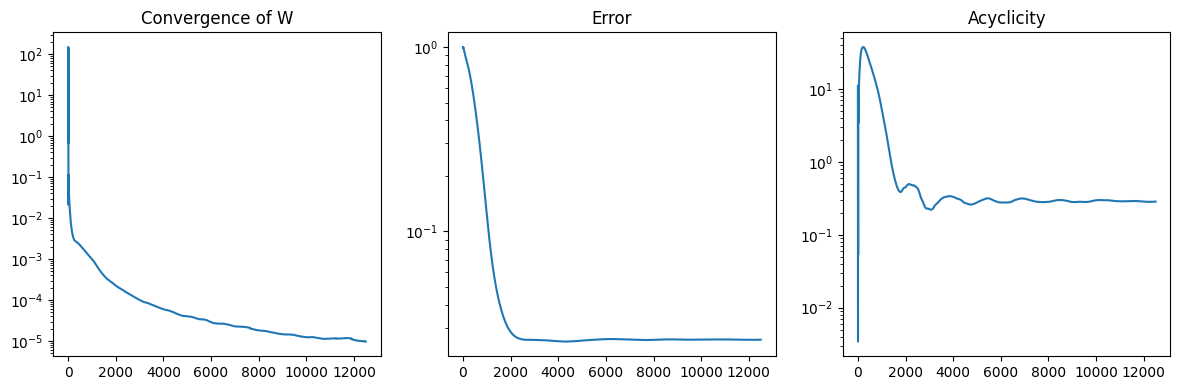

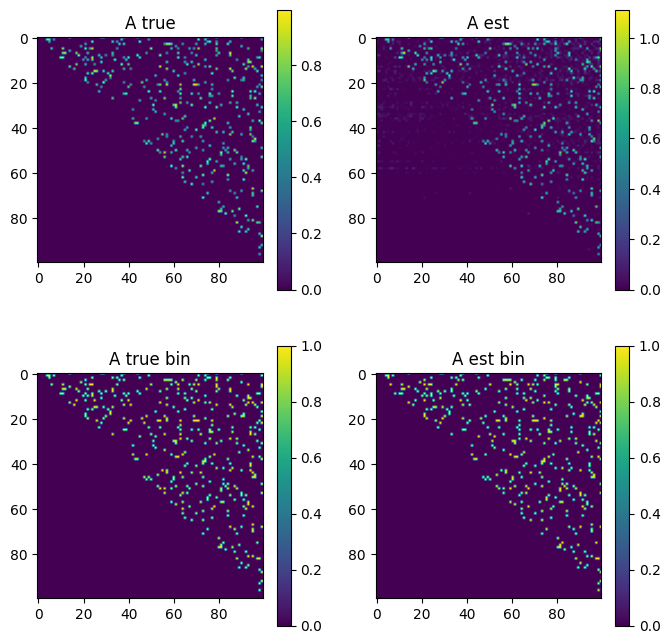

In [5]:
lamb = get_lamb_value(N, M, 2e-4)
args = {'stepsize': 5e-3, 'alpha': .5, 's': 1, 'lamb': lamb, 'max_iters': 20000,
        'tol': 1e-5, 'opt_type': 'fista'}

t_i = time.time()
model_ppgd = Nonneg_dagma()
A_dagma2 = model_ppgd.fit(X, **args, track_seq=True)
t_solved = time.time() - t_i
print(f'Accelerated: Solved in {t_solved:3f} seconds')

# Plot description
thr = .2
print('Mean est value:', A_dagma2.mean())
plot_convergence(model_ppgd, A)
plot_result(A, A_dagma2, thr)

Adam: Solved in 24.644208 seconds
Mean est value: 0.03335056222551282
Err: 0.026  -  Err bin: 0.010  -  shd: 4  -  fscore: 0.995


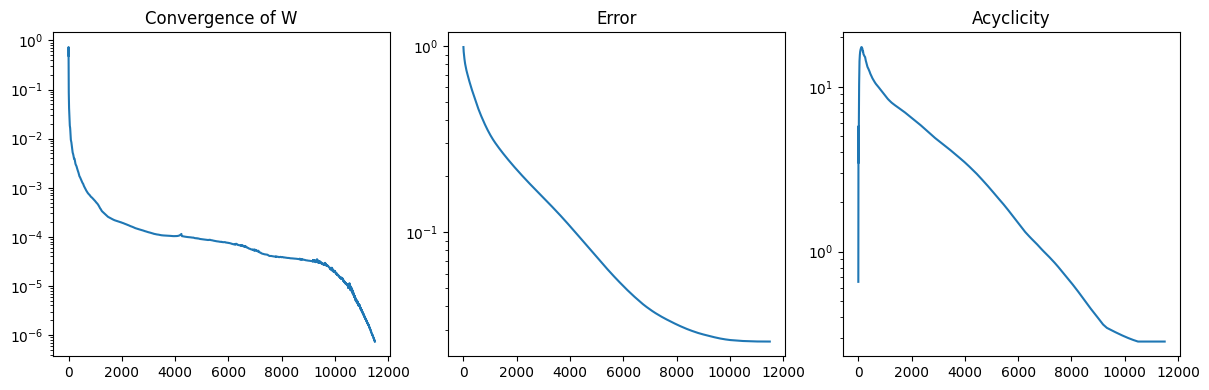

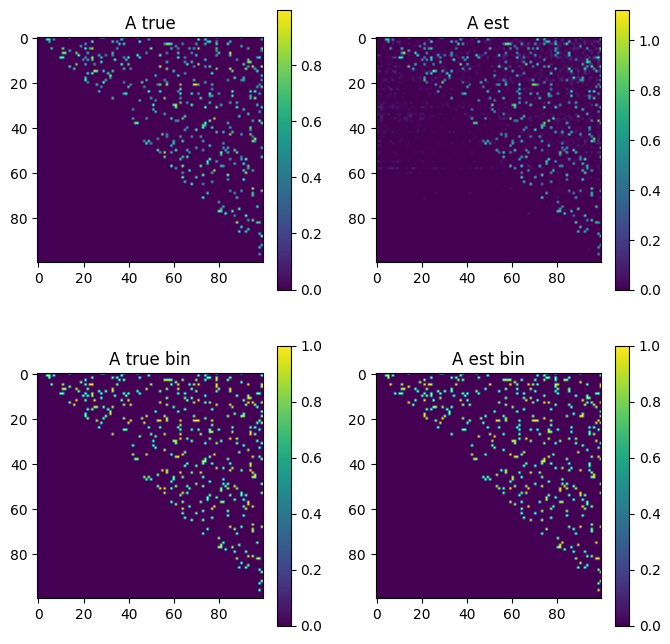

In [6]:
lamb = get_lamb_value(N, M, 2e-4)
args = {'stepsize': 5e-3, 'alpha': .5, 's': 1, 'lamb': lamb, 'max_iters': 20000,
        'tol': 1e-6, 'opt_type': 'adam'}

t_i = time.time()
model_ppgd = Nonneg_dagma()
A_dagma2 = model_ppgd.fit(X, **args, track_seq=True)
t_solved = time.time() - t_i
print(f'Adam: Solved in {t_solved:3f} seconds')

# Plot description
thr = .2
print('Mean est value:', A_dagma2.mean())
plot_convergence(model_ppgd, A)
plot_result(A, A_dagma2, thr)

### Method of Multipliers DAGMA Alg

In [7]:
# ## Second set of hyperparams N = 50
# lamb = get_lamb_value(N, M, 2e-2)
# # 2N LINKS
# # if edges == 2*N:
# #     args = {'stepsize': 5e-2, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': lamb, 'iters_in': 5000,
# #             'iters_out': 10, 'tol': 1e-6, 'beta': 5, 'dec_step': False, 'verb': True}
# #         # args = {'stepsize': 1e-2, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': lamb, 'iters_in': 5000,
# #         #     'iters_out': 10, 'tol': 1e-6, 'beta': 5, 'dec_step': False, 'verb': True}
# # else:
# # # 4N LINKS
# #     lamb = get_lamb_value(N, M, 2e-2)
# #     args = {'stepsize': 1e-3, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': lamb, 'iters_in': 30000,
# #             'iters_out': 10, 'tol': 1e-6, 'beta': 5, 'dec_step': False, 'verb': True}

# # lamb = get_lamb_value(N, M, 5e-3)
# lamb = get_lamb_value(N, M, 2e-4)
# args = {'stepsize': 1e-4, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': lamb, 'iters_in': 30000,
#             'iters_out': 10, 'tol': 1e-6, 'beta': 2, 'verb': True}


# print('lamb:', lamb)

# t_i = time.time()
# model = MetMulDagma()
# A_est = model.fit(X, **args, track_seq=True)
# t_solved = time.time() - t_i
# print(f'Solved in {t_solved:3f} seconds')

# # Plot description
# thr = .2
# print('Mean est value:', A_est.mean())
# plot_convergence(model, A)
# plot_result(A, A_est, thr)

lamb: 0.00047985259121880814


- 1/10. Diff: 0.000089 | Acycl: 8.019233 | Rho: 0.100 - Alpha: 0.812 - Step: 0.0001
- 2/10. Diff: 0.000010 | Acycl: 0.002196 | Rho: 0.100 - Alpha: 0.812 - Step: 0.0001
- 3/10. Diff: 0.000000 | Acycl: 0.002196 | Rho: 0.200 - Alpha: 0.813 - Step: 0.0001
- 4/10. Diff: 0.000000 | Acycl: 0.002196 | Rho: 0.400 - Alpha: 0.813 - Step: 0.0001
- 5/10. Diff: 0.000000 | Acycl: 0.002196 | Rho: 0.800 - Alpha: 0.815 - Step: 0.0001
- 6/10. Diff: 0.000000 | Acycl: 0.002196 | Rho: 1.600 - Alpha: 0.819 - Step: 0.0001
- 7/10. Diff: 0.000000 | Acycl: 0.002196 | Rho: 3.200 - Alpha: 0.826 - Step: 0.0001
- 8/10. Diff: 0.000000 | Acycl: 0.002196 | Rho: 6.400 - Alpha: 0.840 - Step: 0.0001
- 9/10. Diff: 0.000000 | Acycl: 0.002196 | Rho: 12.800 - Alpha: 0.868 - Step: 0.0001
- 10/10. Diff: 0.000000 | Acycl: 0.002196 | Rho: 25.600 - Alpha: 0.924 - Step: 0.0001
Solved in 16.573141 seconds
Mean est value: 0.03218885508130853
Err: 0.020  -  Err bin: 0.003  -  shd: 1  -  fscore: 0.999


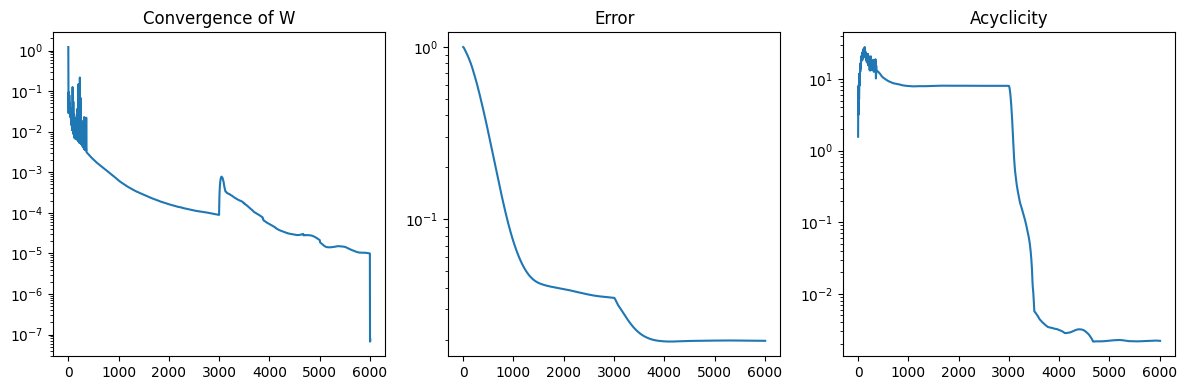

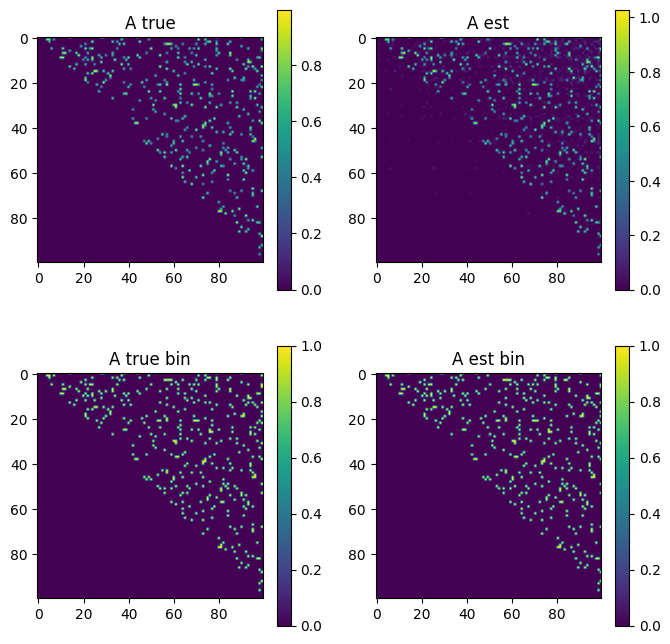

In [8]:
## Second set of hyperparams N = 50
lamb = get_lamb_value(N, M, 5e-3)

args = {'stepsize': 1e-4, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': lamb, 'iters_in': 3000,
            'iters_out': 10, 'tol': 1e-6, 'beta': 2, 'dec_step': None, 'opt_type': 'fista', 'verb': True}

print('lamb:', lamb)

t_i = time.time()
model = MetMulDagma()
A_est = model.fit(X, **args, track_seq=True)
t_solved = time.time() - t_i
print(f'Solved in {t_solved:3f} seconds')

# Plot description
thr = .2
print('Mean est value:', A_est.mean())
plot_convergence(model, A)
plot_result(A, A_est, thr)

lamb: 0.00047985259121880814


- 1/10. Diff: 0.000079 | Acycl: 8.603793 | Rho: 0.100 - Alpha: 0.870 - Step: 0.0003
- 2/10. Diff: 0.000001 | Acycl: 0.002246 | Rho: 0.100 - Alpha: 0.871 - Step: 0.0003
- 3/10. Diff: 0.000000 | Acycl: 0.002245 | Rho: 0.200 - Alpha: 0.871 - Step: 0.0003
- 4/10. Diff: 0.000000 | Acycl: 0.002242 | Rho: 0.400 - Alpha: 0.872 - Step: 0.0003
- 5/10. Diff: 0.000000 | Acycl: 0.002236 | Rho: 0.800 - Alpha: 0.874 - Step: 0.0003
- 6/10. Diff: 0.000000 | Acycl: 0.002224 | Rho: 1.600 - Alpha: 0.877 - Step: 0.0003
- 7/10. Diff: 0.000001 | Acycl: 0.002200 | Rho: 3.200 - Alpha: 0.884 - Step: 0.0003
- 8/10. Diff: 0.000000 | Acycl: 0.002149 | Rho: 6.400 - Alpha: 0.898 - Step: 0.0003
- 9/10. Diff: 0.000001 | Acycl: 0.002024 | Rho: 12.800 - Alpha: 0.924 - Step: 0.0003
- 10/10. Diff: 0.000000 | Acycl: 0.001933 | Rho: 25.600 - Alpha: 0.973 - Step: 0.0003
Solved in 67.859561 seconds
Mean est value: 0.032183772626282914
Err: 0.020  -  Err bin: 0.003  -  shd: 1  -  fscore: 0.999


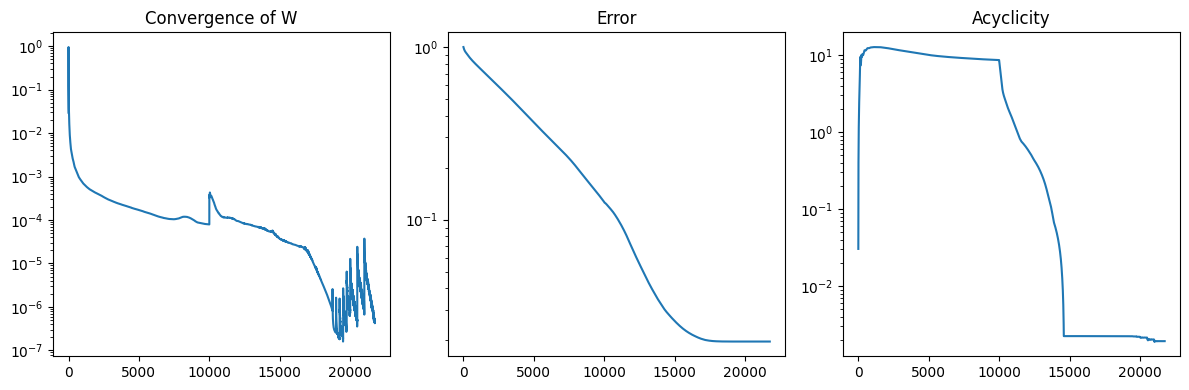

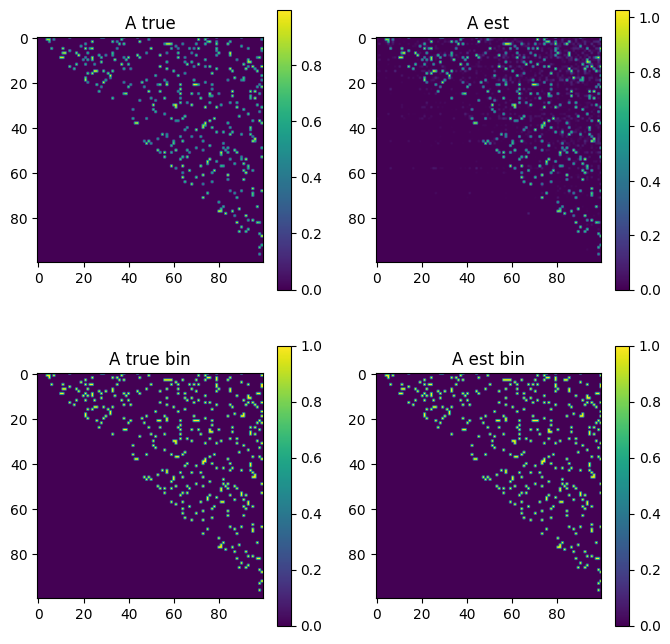

In [9]:
## Second set of hyperparams N = 50
lamb = get_lamb_value(N, M, 5e-3)
args = {'stepsize': 3e-4, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': lamb, 'iters_in': 10000,
            'iters_out': 10, 'tol': 1e-6, 'beta': 2, 'opt_type': 'adam', 'verb': True}

# args = {'stepsize': 1e-4, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': lamb, 'iters_in': 3000,
#             'iters_out': 15, 'tol': 1e-6, 'beta': 2, 'opt_type': 'adam', 'verb': True}

print('lamb:', lamb)

t_i = time.time()
model = MetMulDagma()
A_est = model.fit(X, **args, track_seq=True)
t_solved = time.time() - t_i
print(f'Solved in {t_solved:3f} seconds')

# Plot description
thr = .2
print('Mean est value:', A_est.mean())
plot_convergence(model, A)
plot_result(A, A_est, thr)

### Logarithmic barrier DAGMA Alg

In [10]:
# ## Second set of hyperparams N = 50

# lamb = get_lamb_value(N, M, 2e-2)
# print('lamb:', lamb)
# if norm_x:
#     lamb = get_lamb_value(N, M, 2e-4)
#     args = {'stepsize': 5e-1, 'alpha': 5e-3, 's': 1, 'lamb': lamb, 'iters_in': 5000,
#             'iters_out': 10, 'tol': 1e-6, 'beta': .5, 'verb': True}
# else:
#     lamb = get_lamb_value(N, M, 2e-2)
#     args = {'stepsize': 2e-2, 'alpha': .01, 's': 1, 'lamb': lamb, 'iters_in': 100,
#             'iters_out': 100, 'tol': 1e-6, 'beta': .9, 'verb': True}


# t_i = time.time()
# model = BarrierDagma()
# A_est = model.fit(X, **args, track_seq=True)
# t_solved = time.time() - t_i
# print(f'Solved in {t_solved:3f} seconds')

# # Plot description
# thr = .2
# plot_convergence(model, A)
# plot_result(A, A_est, thr)

## Comparing models - Unit variance - 4N Edges

In [11]:
Exps = [
    # Not norm
    {'model': Nonneg_dagma, 'args': {'stepsize': 5e-3, 'alpha': .5, 's': 1, 'lamb': 2e-2, 'max_iters': 70000},  # TOP!
     'fix_lamb': False, 'leg': 'PGD'},

    {'model': Nonneg_dagma, 'args': {'stepsize': 5e-3, 'alpha': .5, 's': 1, 'lamb': 2e-2, 'max_iters': 20000,
     'opt_type': 'fista', 'tol': 1e-5}, 'fix_lamb': False, 'leg': 'PGD-FISTA'},

    {'model': Nonneg_dagma, 'args': {'stepsize': 5e-3, 'alpha': .5, 's': 1, 'lamb': 2e-2, 'max_iters': 20000,
     'opt_type': 'adam', 'tol': 1e-5}, 'fix_lamb': False, 'leg': 'PGD-Adam'},


    {'model': MetMulDagma, 'args': {'stepsize': 2.5e-3, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': 5e-3,
     'iters_in': 30000, 'iters_out': 10, 'beta': 2, 'dec_step': False}, 'norm_x': False, 'fix_lamb': False,
     'leg': 'Mult'},

    {'model': MetMulDagma, 'args': {'stepsize': 1e-4, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': 5e-3,
     'iters_in': 30000, 'iters_out': 10, 'beta': 2, 'dec_step': False}, 'norm_x': False, 'fix_lamb': False,
     'leg': 'Mult-v2'},


    {'model': MetMulDagma, 'args': {'stepsize': 1e-4, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': 5e-3,
     'iters_in': 5000, 'iters_out': 10, 'beta': 2, 'opt_type': 'fista'}, 'norm_x': False, 'fix_lamb': False,
     'leg': 'Mult-FISTA'},

    {'model': MetMulDagma, 'args': {'stepsize': 1e-4, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': 5e-3,
     'iters_in': 300, 'iters_out': 10, 'beta': 2, 'opt_type': 'fista'}, 'norm_x': False, 'fix_lamb': False,
     'leg': 'Mult-FISTA-v2'},    

    {'model': MetMulDagma, 'args': {'stepsize': 3e-4, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': 5e-3,
     'iters_in': 10000, 'iters_out': 10, 'beta': 2, 'opt_type': 'adam'}, 'norm_x': False, 'fix_lamb': False,
     'leg': 'Mult-adam'},

     {'model': MetMulDagma, 'args': {'stepsize': 3e-4, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': 5e-3,
     'iters_in': 5000, 'iters_out': 10, 'beta': 2, 'opt_type': 'adam'}, 'norm_x': False, 'fix_lamb': False,
     'leg': 'Mult-adam'},
            

    # Colide
    {'model': colide_ev, 'args': {'lambda1': .05, 'T': 4, 's': [1.0, .9, .8, .7], 'warm_iter': 2e4,
     'max_iter': 7e4, 'lr': .0003}, 'norm_x': False, 'leg': 'CoLiDe-Paper_regs-notnorm'},

]

In [12]:
N = 100

n_dags = 25
data_params = {
    'n_nodes': N,
    'n_samples': 500, # 1000,
    'graph_type': 'er',
    'edges': 4*N,
    'edge_type': 'positive',
    'w_range': (.5, 1),
    'var': 1
}

print('CPUs employed:', N_CPUS)

t_init = time.time()
results = Parallel(n_jobs=N_CPUS)(delayed(run_exps)(g, data_params, Exps, thr=.2, verb=False) for g in range(n_dags))
ellapsed_time = time.time() - t_init
print(f'----- Solved in {ellapsed_time:.3f} seconds -----')

# Extract results
shd, fscore, err, acyc, runtime = zip(*results)
metrics = {'shd': shd, 'fscore': fscore, 'err': err, 'acyc': acyc, 'time': runtime}


CPUs employed: 32


18: Fidelity: 100.600  -  Fidelity (norm): 0.019
2: Fidelity: 100.133  -  Fidelity (norm): 0.010
7: Fidelity: 100.135  -  Fidelity (norm): 0.029
12: Fidelity: 99.904  -  Fidelity (norm): 0.012
13: Fidelity: 100.486  -  Fidelity (norm): 0.009
14: Fidelity: 100.471  -  Fidelity (norm): 0.019
24: Fidelity: 99.530  -  Fidelity (norm): 0.006
1: Fidelity: 99.915  -  Fidelity (norm): 0.020
22: Fidelity: 100.176  -  Fidelity (norm): 0.014
19: Fidelity: 99.544  -  Fidelity (norm): 0.019
21: Fidelity: 100.148  -  Fidelity (norm): 0.027
17: Fidelity: 100.146  -  Fidelity (norm): 0.014
16: Fidelity: 100.361  -  Fidelity (norm): 0.019
10: Fidelity: 100.468  -  Fidelity (norm): 0.036
20: Fidelity: 99.317  -  Fidelity (norm): 0.012
8: Fidelity: 100.592  -  Fidelity (norm): 0.010
4: Fidelity: 100.516  -  Fidelity (norm): 0.024
6: Fidelity: 100.034  -  Fidelity (norm): 0.017
23: Fidelity: 100.027  -  Fidelity (norm): 0.019
0: Fidelity: 100.732  -  Fidelity (norm): 0.018
3: Fidelity: 100.824  -  Fidelit

100%|██████████| 130000/130000.0 [00:27<00:00, 4661.94it/s] 
100%|██████████| 130000/130000.0 [00:27<00:00, 4801.18it/s] 
100%|██████████| 130000/130000.0 [00:33<00:00, 3901.96it/s] 
100%|██████████| 130000/130000.0 [00:41<00:00, 3152.91it/s]
100%|██████████| 130000/130000.0 [00:28<00:00, 4578.40it/s] 
100%|██████████| 130000/130000.0 [00:44<00:00, 2943.82it/s]
100%|██████████| 130000/130000.0 [00:50<00:00, 2560.61it/s]
100%|██████████| 130000/130000.0 [00:34<00:00, 3715.35it/s] 
100%|██████████| 130000/130000.0 [00:42<00:00, 3074.43it/s]
100%|██████████| 130000/130000.0 [00:38<00:00, 3405.92it/s] 
100%|██████████| 130000/130000.0 [00:43<00:00, 2986.26it/s]
100%|██████████| 130000/130000.0 [00:38<00:00, 3393.12it/s]
100%|██████████| 130000/130000.0 [00:31<00:00, 4158.11it/s] 
100%|██████████| 130000/130000.0 [00:34<00:00, 3718.02it/s] 
100%|██████████| 130000/130000.0 [00:40<00:00, 3221.50it/s]
100%|██████████| 130000/130000.0 [00:33<00:00, 3913.32it/s]
100%|██████████| 130000/130000.0

----- Solved in 714.445 seconds -----


100%|██████████| 130000/130000.0 [00:42<00:00, 3033.98it/s]


In [13]:
exps_leg = [exp['leg'] for exp in Exps]
utils.display_results(exps_leg, metrics, agg='mean')
utils.display_results(exps_leg, metrics, agg='median')
utils.display_results(exps_leg, metrics, agg='std')

,leg,shd,fscore,err,acyc,time
0,PGD,207.12,0.663509,0.565356,17.780965,47.773713
1,PGD-FISTA,35.60,0.951826,0.095137,0.851970,10.674954
2,PGD-Adam,3.00,0.996144,0.023837,0.346283,12.492204
3,Mult,60.28,0.922211,0.134774,0.002097,199.438100
4,Mult-v2,58.88,0.927753,0.128051,0.003759,199.616321
5,Mult-FISTA,157.28,0.767912,0.359545,0.132940,16.570414
6,Mult-FISTA-v2,263.40,0.460729,0.826316,0.737418,2.274689
7,Mult-adam,6.56,0.991555,0.026320,0.000828,25.431748
8,Mult-adam,13.36,0.981838,0.035422,0.000430,21.426122
9,CoLiDe-Paper_regs-notnorm,34.88,0.945714,0.083511,0.000294,36.923572


,leg,shd,fscore,err,acyc,time
0,PGD,139.724105,0.289441,0.434755,10.620214,5.283945
1,PGD-FISTA,88.598420,0.130644,0.230287,2.136259,2.790977
2,PGD-Adam,2.135416,0.002809,0.003540,0.191482,3.667480
3,Mult,86.270514,0.116957,0.184146,0.005108,56.325001
4,Mult-v2,71.580064,0.084344,0.144193,0.007193,46.143237
5,Mult-FISTA,127.842566,0.257262,0.401999,0.405682,7.223184
6,Mult-FISTA-v2,160.800498,0.398439,0.610115,0.974098,0.396398
7,Mult-adam,6.444098,0.007766,0.006625,0.000597,5.120810
8,Mult-adam,10.725223,0.013974,0.013481,0.000321,3.340419
9,CoLiDe-Paper_regs-notnorm,15.487595,0.021569,0.025896,0.000035,6.563450


,leg,shd,fscore,err,acyc,time
0,PGD,160.0,0.798942,0.382881,16.544934,49.324316
1,PGD-FISTA,3.0,0.996283,0.024344,0.376246,9.590474
2,PGD-Adam,2.0,0.997436,0.023062,0.339080,14.833961
3,Mult,26.0,0.966161,0.062369,0.000431,212.860098
4,Mult-v2,32.0,0.960479,0.065990,0.000507,192.268954
5,Mult-FISTA,151.0,0.838565,0.224907,0.013195,16.826194
6,Mult-FISTA-v2,383.0,0.343333,0.896183,0.063010,2.438234
7,Mult-adam,5.0,0.993939,0.024607,0.000581,24.119315
8,Mult-adam,9.0,0.987923,0.031684,0.000352,20.649113
9,CoLiDe-Paper_regs-notnorm,33.0,0.949891,0.082543,0.000292,34.966913


## Comparing methods - 2N Edges

In [14]:
Exps = [
    # Not norm
    {'model': Nonneg_dagma, 'args': {'stepsize': 5e-3, 'alpha': .5, 's': 1, 'lamb': 2e-2, 'max_iters': 70000},  # TOP!
     'fix_lamb': False, 'leg': 'PGD'},

    {'model': Nonneg_dagma, 'args': {'stepsize': 5e-3, 'alpha': .5, 's': 1, 'lamb': 2e-2, 'max_iters': 20000,
     'opt_type': 'fista', 'tol': 1e-5}, 'fix_lamb': False, 'leg': 'PGD-FISTA'},

    {'model': Nonneg_dagma, 'args': {'stepsize': 5e-3, 'alpha': .5, 's': 1, 'lamb': 2e-2, 'max_iters': 20000,
     'opt_type': 'adam', 'tol': 1e-5}, 'fix_lamb': False, 'leg': 'PGD-Adam'},


    {'model': MetMulDagma, 'args': {'stepsize': 2.5e-3, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': 5e-3,
     'iters_in': 30000, 'iters_out': 10, 'beta': 2, 'dec_step': False}, 'norm_x': False, 'fix_lamb': False,
     'leg': 'Mult'},

    {'model': MetMulDagma, 'args': {'stepsize': 1e-4, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': 5e-3,
     'iters_in': 5000, 'iters_out': 10, 'beta': 2, 'opt_type': 'fista'}, 'norm_x': False, 'fix_lamb': False,
     'leg': 'Mult-FISTA'},

    {'model': MetMulDagma, 'args': {'stepsize': 3e-4, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': 5e-3,
     'iters_in': 10000, 'iters_out': 10, 'beta': 2, 'opt_type': 'adam'}, 'norm_x': False, 'fix_lamb': False,
     'leg': 'Mult-Adam'},
    

    # Colide
    {'model': colide_ev, 'args': {'lambda1': .05, 'T': 4, 's': [1.0, .9, .8, .7], 'warm_iter': 2e4,
     'max_iter': 7e4, 'lr': .0003}, 'norm_x': False, 'leg': 'CoLiDe-Paper_regs-notnorm'},

]

### 100 nodes and 2N edges

In [15]:
###  1000 samples - 100 nodes  #####
N = 100

n_dags = 25
data_params = {
    'n_nodes': N,
    'n_samples': 500, # 1000,
    'graph_type': 'er',
    'edges': 2*N,
    'edge_type': 'positive',
    'w_range': (.5, 1),
    'var': 1,
}

print('CPUs employed:', N_CPUS)

t_init = time.time()
results = Parallel(n_jobs=N_CPUS)(delayed(run_exps)(g, data_params, Exps, thr=.2, verb=False) for g in range(n_dags))
ellapsed_time = time.time() - t_init
print(f'----- Solved in {ellapsed_time:.3} seconds -----')

# Extract results
shd, fscore, err, acyc, runtime = zip(*results)
metrics = {'shd': shd, 'fscore': fscore, 'err': err, 'acyc': acyc, 'time': runtime}


CPUs employed: 32
0: Fidelity: 99.166  -  Fidelity (norm): 0.221
2: Fidelity: 99.166  -  Fidelity (norm): 0.185
4: Fidelity: 99.166  -  Fidelity (norm): 0.178
1: Fidelity: 99.166  -  Fidelity (norm): 0.319
5: Fidelity: 99.166  -  Fidelity (norm): 0.229
3: Fidelity: 99.166  -  Fidelity (norm): 0.231
6: Fidelity: 99.166  -  Fidelity (norm): 0.311
7: Fidelity: 99.166  -  Fidelity (norm): 0.206
8: Fidelity: 99.166  -  Fidelity (norm): 0.226
9: Fidelity: 99.166  -  Fidelity (norm): 0.206
10: Fidelity: 99.166  -  Fidelity (norm): 0.245
11: Fidelity: 99.166  -  Fidelity (norm): 0.180
12: Fidelity: 99.166  -  Fidelity (norm): 0.194
13: Fidelity: 99.166  -  Fidelity (norm): 0.283
14: Fidelity: 99.166  -  Fidelity (norm): 0.210
15: Fidelity: 99.166  -  Fidelity (norm): 0.229
16: Fidelity: 99.166  -  Fidelity (norm): 0.358
17: Fidelity: 99.166  -  Fidelity (norm): 0.297
18: Fidelity: 99.166  -  Fidelity (norm): 0.248
19: Fidelity: 99.166  -  Fidelity (norm): 0.228
20: Fidelity: 99.166  -  Fidelit

100%|██████████| 130000/130000.0 [00:21<00:00, 6171.93it/s] 
100%|██████████| 130000/130000.0 [00:28<00:00, 4486.19it/s] 
100%|██████████| 130000/130000.0 [00:28<00:00, 4621.32it/s] 
100%|██████████| 130000/130000.0 [00:28<00:00, 4612.30it/s] 
100%|██████████| 130000/130000.0 [00:22<00:00, 5821.90it/s] 
100%|██████████| 130000/130000.0 [00:29<00:00, 4362.23it/s] 
100%|██████████| 130000/130000.0 [00:30<00:00, 4285.91it/s]
100%|██████████| 130000/130000.0 [00:33<00:00, 3901.07it/s] 
100%|██████████| 130000/130000.0 [00:33<00:00, 3871.91it/s] 
100%|██████████| 130000/130000.0 [00:33<00:00, 3875.24it/s]
100%|██████████| 130000/130000.0 [00:31<00:00, 4077.70it/s]
100%|██████████| 130000/130000.0 [00:34<00:00, 3718.60it/s]
100%|██████████| 130000/130000.0 [00:31<00:00, 4155.71it/s] 
100%|██████████| 130000/130000.0 [00:33<00:00, 3881.74it/s] 
100%|██████████| 130000/130000.0 [00:31<00:00, 4095.52it/s] 
100%|██████████| 130000/130000.0 [00:30<00:00, 4237.61it/s] 
100%|██████████| 130000/1300

----- Solved in 1.54e+02 seconds -----


100%|██████████| 130000/130000.0 [00:20<00:00, 6347.54it/s] 


In [16]:
# M = 1000
exps_leg = [exp['leg'] for exp in Exps]
utils.display_results(exps_leg, metrics, agg='mean')
utils.display_results(exps_leg, metrics, agg='median')
utils.display_results(exps_leg, metrics, agg='std')

,leg,shd,fscore,err,acyc,time
0,PGD,1.80,0.995388,0.032284,0.624380,18.634021
1,PGD-FISTA,40.92,0.875804,0.224831,3.526790,8.290687
2,PGD-Adam,0.24,0.999308,0.026769,0.569886,4.231127
3,Mult,1.04,0.996322,0.030347,0.004049,36.321305
4,Mult-FISTA,33.64,0.912528,0.159136,0.016506,13.484989
5,Mult-Adam,2.92,0.989812,0.035440,0.003954,19.161861
6,CoLiDe-Paper_regs-notnorm,6.52,0.977802,0.039806,0.000086,29.408178


,leg,shd,fscore,err,acyc,time
0,PGD,0.0,1.000000,0.025899,0.596374,14.466523
1,PGD-FISTA,1.0,0.993902,0.038566,0.655806,5.957353
2,PGD-Adam,0.0,1.000000,0.026070,0.586436,4.240983
3,Mult,0.0,1.000000,0.030166,0.004057,36.322700
4,Mult-FISTA,9.0,0.969977,0.052080,0.005139,9.011104
5,Mult-Adam,2.0,0.990338,0.033231,0.003628,16.977701
6,CoLiDe-Paper_regs-notnorm,6.0,0.980488,0.034540,0.000078,29.802361


,leg,shd,fscore,err,acyc,time
0,PGD,8.009994,0.020593,0.030982,0.234786,8.807486
1,PGD-FISTA,63.463955,0.237048,0.389125,6.153034,5.762660
2,PGD-Adam,0.649923,0.002012,0.005039,0.108674,0.939624
3,Mult,1.561538,0.005708,0.006125,0.000729,3.307476
4,Mult-FISTA,43.501614,0.110127,0.177565,0.052828,6.196431
5,Mult-Adam,2.827296,0.009274,0.009578,0.001249,3.792055
6,CoLiDe-Paper_regs-notnorm,5.933768,0.018602,0.024873,0.000026,3.860084
